In [2]:
# imports
import pandas as pd
import  numpy as np
import ast
import json
import datetime
#from fastai.imports import *
#from fastai.tabular import *
from sklearn.preprocessing import MultiLabelBinarizer
import ast

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

# read files and fix dates
train = pd.read_csv('C:/Users/or.kornboim/Documents/GitHub/Kaggle_TMDB_Box_Office_Prediction/Data/train.csv',
                    parse_dates=['release_date'],
                   index_col='id')
test = pd.read_csv('C:/Users/or.kornboim/Documents/GitHub/Kaggle_TMDB_Box_Office_Prediction/Data/test.csv',
                  parse_dates=['release_date'],
                   index_col='id')

# Date Fix
train['release_date'] = train['release_date'].mask(train['release_date'].dt.year > 2017, 
                                                   train['release_date'] - pd.offsets.DateOffset(years=100))
test['release_date'] = test['release_date'].mask(test['release_date'].dt.year > 2017, 
                                                   test['release_date'] - pd.offsets.DateOffset(years=100))
# dict columns
#dict_columns = ['belongs_to_collection', 'genres', 'production_companies', 'cast']

mlb = MultiLabelBinarizer()

In [4]:
def convert_string_to_list(strVal):
    if type(strVal) is not str:
        return  []
    else:
        return ast.literal_eval(strVal)
    
def format_dict_column_and_extract_names(strVal, col="name"):
    listOfItems = convert_string_to_list(strVal)
    
    return list(map(lambda x: x[col], listOfItems))

def extract_genres(df):
    df['genres'] = df['genres'].apply(format_dict_column_and_extract_names)
    
    return df.join(pd.DataFrame(mlb.fit_transform(df.pop('genres')),
                                columns=list(map(lambda x: 'genre_'+x, mlb.classes_)),index=df.index))

def extract_common(df, col='production_companies', limit=30):
    df[col] = df[col].apply(format_dict_column_and_extract_names)
    companiesCount = df[col].apply(pd.Series).stack().value_counts()
    companiesToKeep = companiesCount[companiesCount > limit].keys()
    
    #print("We'll keep the companies that appear more than 30 times:")
    #print(companiesToKeep)
    
    df[col] = df[col].apply(lambda x: list(filter(lambda i: i in companiesToKeep, x)))
    
    return df.join(pd.DataFrame(mlb.fit_transform(df.pop(col)),
                          columns=list(map(lambda x: col+'_'+x,mlb.classes_)),
                          index=df.index))

def add_x_length_column(df, col='cast'):
    castNames = df[col].apply(format_dict_column_and_extract_names)
    df[col + '_size'] = castNames.apply(lambda x: len(x))
    df.drop([col], axis=1, inplace=True)
    
    return df

def last_year_metrics(df, agg_col='release_Year', calc_col=['revenue','imdb_id'], leg=1):
    temp = df.groupby([agg_col]).agg({calc_col[0]: 'mean', calc_col[1]: 'count'}).shift(leg).reset_index()
    temp = temp.rename(index=str, columns={'revenue':'last_period_revenue',
                                           'imdb_id': 'last_period_movie_count'})
    
    return pd.merge(df, temp, on=['release_Year'], how='left')

def days_diff_from_last_movie(df, col='release_date'):#see if there is a need in buckts
    df = df.sort_values(by=[col])
    df['days_diff_from_last_movie'] = df[col].diff().fillna(0)
    
    return df

def ratios(df):
    df['budget_to_runtime'] = df['budget']/df['runtime']
    df['budget_to_cast_crew_size'] = df['budget']/(df['cast_size'] + df['crew_size'])
    
    return df


df = extract_genres(train)
df = extract_common(df, col='production_companies', limit=30)
df = extract_common(df, col='production_countries', limit=20)
df = extract_common(df, col='spoken_languages', limit=10)
df = add_x_length_column(df, col='cast')
df = add_x_length_column(df, col='crew')
#df = add_datepart(df, 'release_date', drop=False) 
#df = last_year_metrics(df)
df = days_diff_from_last_movie(df)
df = ratios(df)


df['belongs_to_collection_bool'] = np.where(df['belongs_to_collection'].isna(), 0, 1)
df.drop(['belongs_to_collection'], axis=1, inplace=True)


df.head(3)


C:\Users\or.kornboim\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western,production_companies_Canal+,production_companies_Columbia Pictures,production_companies_Columbia Pictures Corporation,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_Miramax Films,production_companies_New Line Cinema,production_companies_Paramount Pictures,production_companies_Regency Enterprises,production_companies_Relativity Media,production_companies_Touchstone Pictures,production_companies_TriStar Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_United Artists,production_companies_Universal Pictures,production_companies_Village Roadshow Pictures,production_companies_Walt Disney Pictures,production_companies_Warner Bros.,production_countries_Australia,production_countries_Belgium,production_countries_Canada,production_countries_China,production_countries_France,production_countries_Germany,production_countries_Hong Kong,production_countries_India,production_countries_Ireland,production_countries_Italy,production_countries_Japan,production_countries_Russia,production_countries_South Korea,production_countries_Spain,production_countries_United Kingdom,production_countries_United States of America,spoken_languages_,spoken_languages_Dansk,spoken_languages_Deutsch,spoken_languages_English,spoken_languages_Español,spoken_languages_Français,spoken_languages_Italiano,spoken_languages_Latin,spoken_languages_Magyar,spoken_languages_Polski,spoken_languages_Português,spoken_languages_Pусский,spoken_languages_Türkçe,spoken_languages_svenska,spoken_languages_Český,spoken_languages_ελληνικά,spoken_languages_עִבְרִית,spoken_languages_العربية,spoken_languages_हिन्दी,spoken_languages_தமிழ்,spoken_languages_ภาษาไทย,spoken_languages_广州话 / 廣州話,spoken_languages_日本語,spoken_languages_普通话,spoken_languages_한국어/조선말,cast_size,crew_size,days_diff_from_last_movie,budget_to_runtime,budget_to_cast_crew_size,belongs_to_collection_bool
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1764,250000,NaN,tt0012349,en,The Kid,Considered one of Charlie Chaplin's best films...,8.17,/drgMcyTsySQBnUPGaBThCHGdlWT.jpg,1921-01-21,68.00,Released,6 reels of Joy.,The Kid,"[{'id': 290, 'name': 'angel'}, {'id': 1252, 'n...",2500000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,12,0 days,3676.47,5319.15,0
2993,1135654,NaN,tt0015400,en,The Thief of Bagdad,A recalcitrant thief vies with a duplicitous M...,3.88,/a6IzXkwZRDimfn8HATzP6Pi6Ois.jpg,1924-03-18,149.00,Released,"""Happiness Must Be Earned""",The Thief of Bagdad,"[{'id': 255, 'name': 'male nudity'}, {'id': 14...",1213880,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,28,1152 days,7621.84,23176.61,0
1918,592,NaN,tt0016104,en,The Merry Widow,Prince Danilo falls in love with dancer Sally ...,0.29,/dCVkB0POblxtn3BegTNcwTPMKUP.jpg,1925-08-26,137.00,Released,NaN,The Merry Widow,"[{'id': 1691, 'name': 'dance'}, {'id': 10181, ...",1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,17,526 days,4.32,23.68,0


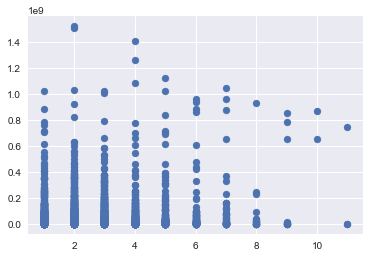

                      original_title_words  revenue
original_title_words                  1.00     0.11
revenue                               0.11     1.00


In [44]:
# counting the numbers of words in the movie title 
df['original_title_words'] = df.original_title.str.split()
df['original_title_words'] = df['original_title_words'].apply(lambda x: len(x)) 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

#sns.swarmplot(x='original_title_words',y='revenue', data = df)
plt.scatter(df['original_title_words'],df['revenue'])
plt.show()

print(df[['original_title_words','revenue']].corr())

In [86]:
# number of Geners per movie
df['geners_count'] =\
df[['genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
   'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Foreign',
   'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance',
   'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western']].sum(axis=1)

print(df[['geners_count','revenue']].corr())
df['geners_count'].describe()

              geners_count  revenue
geners_count          1.00     0.16
revenue               0.16     1.00
None


count   3000.00
mean       2.50
std        1.12
min        0.00
25%        2.00
50%        2.00
75%        3.00
max        7.00
Name: geners_count, dtype: float64

In [92]:
df['production_companies_count'] =\
df[['production_companies_Canal+', 'production_companies_Columbia Pictures',
    'production_companies_Columbia Pictures Corporation', 'production_companies_Metro-Goldwyn-Mayer (MGM)',
    'production_companies_Miramax Films', 'production_companies_New Line Cinema', 'production_companies_Paramount Pictures',
    'production_companies_Regency Enterprises', 'production_companies_Relativity Media',
    'production_companies_Touchstone Pictures', 'production_companies_TriStar Pictures',
    'production_companies_Twentieth Century Fox Film Corporation', 'production_companies_United Artists',
    'production_companies_Universal Pictures', 'production_companies_Village Roadshow Pictures',
    'production_companies_Walt Disney Pictures', 'production_companies_Warner Bros.',
    'production_countries_Australia', 'production_countries_Belgium', 'production_countries_Canada',
    'production_countries_China', 'production_countries_France', 'production_countries_Germany',
    'production_countries_Hong Kong', 'production_countries_India', 'production_countries_Ireland',
    'production_countries_Italy', 'production_countries_Japan', 'production_countries_Russia',
    'production_countries_South Korea', 'production_countries_Spain', 'production_countries_United Kingdom',
    'production_countries_United States of America']].sum(axis=1,)

print(df[['production_companies_count','revenue']].corr())
df['production_companies_count'].value_counts()

                            production_companies_count  revenue
production_companies_count                        1.00     0.23
revenue                                           0.23     1.00


1    1267
2    1202
3     319
0      96
4      88
5      23
6       5
Name: production_companies_count, dtype: int64

In [93]:
df.columns[0:]

Index(['budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'release_date', 'runtime',
       ...
       'spoken_languages_한국어/조선말', 'cast_size', 'crew_size', 'days_diff_from_last_movie', 'budget_to_runtime', 'budget_to_cast_crew_size', 'belongs_to_collection_bool', 'original_title_words', 'geners_count', 'production_companies_count'], dtype='object', length=102)

In [7]:
[col for col in df if col.startswith('genre_')]

['genre_Action',
 'genre_Adventure',
 'genre_Animation',
 'genre_Comedy',
 'genre_Crime',
 'genre_Documentary',
 'genre_Drama',
 'genre_Family',
 'genre_Fantasy',
 'genre_Foreign',
 'genre_History',
 'genre_Horror',
 'genre_Music',
 'genre_Mystery',
 'genre_Romance',
 'genre_Science Fiction',
 'genre_TV Movie',
 'genre_Thriller',
 'genre_War',
 'genre_Western']